# Imports and helper functions

In [1]:
import torch
import scipy
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from types import SimpleNamespace
from tqdm.autonotebook import tqdm
import gc
from scipy.optimize import minimize, OptimizeResult

# Set seeds for reproducibility
seed = 0
random.seed(seed)     
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def min_max_scaling(x, axis=0):
    """ Normalize input across given axis. """
    xmax = np.max(x, axis=axis, keepdims=True)
    xmin = np.min(x, axis=axis, keepdims=True)
    return (x - xmin)/(xmax - xmin)

def balance_panels(X, y, panels):
    _, J, K = X.shape
    _, p_obs = np.unique(panels, return_counts=True)
    p_obs = (p_obs/J).astype(int)
    N = len(p_obs)  # New N after accounting for panels
    P = np.max(p_obs)  # Panel length for all records

    Xbal, ybal, panel_info = np.zeros((N*P, J, K)), np.zeros((N*P, J)), np.zeros((N, P), dtype=bool)
    cum_p = 0  # Cumulative sum of n_obs at every iteration
    for n, p in enumerate(p_obs):
        # Copy data from original to balanced version
        Xbal[n*P:n*P + p, :, :] = X[cum_p:cum_p + p, :, :]
        ybal[n*P:n*P + p, :] = y[cum_p:cum_p + p, :] 
        panel_info[n, :p] = True #np.ones(p)
        cum_p += p
    return Xbal.reshape(N, P, J, K), ybal.reshape(N, P, J), panel_info

def batches_idx(batch_size, n_samples):
    batch_size = n_samples if batch_size is None else min(n_samples, batch_size)
    n_batches = n_samples//batch_size + int(n_samples % batch_size != 0)
    return [(batch*batch_size, batch*batch_size + batch_size) \
        for batch in range(n_batches)]

/tmp/ipykernel_17811/4217639618.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Data Generation

In [2]:
def generate_dataset(dgp=None, n_indiv=10_000, n_panels=10, n_alt=4):
    if dgp == 'simul-mnl-1':
        betas = np.array([-1.0, 1.0, 2.0])
        coeff = betas
    
        n_attr = coeff.shape[-1]
        # Generate x_i data and compute utilities
        X = np.random.uniform(low=-1, high=1, size=(n_indiv, n_panels, n_alt, n_attr))
        V = np.einsum("npjk,k -> npj", X, coeff)

    if dgp == 'simul-indep-norm':
        betas = np.array([-1, 1.0, 2.0, 1.5, 2.5])
        beta_0 = betas[0]
        mu, omega = betas[[1, 2]], np.diag(betas[[3, 4]])
    
        # Generate coefficients
        coeff = np.hstack((np.full((n_indiv, 1), beta_0),
                           np.random.multivariate_normal(mu, omega, n_indiv)))  # (n_indiv, 4)
        n_attr = coeff.shape[-1]
        # Generate x_i data and compute utilities
        X = np.random.uniform(low=-1, high=1, size=(n_indiv, n_panels, n_alt, n_attr))
        V = np.einsum("npjk,nk -> npj", X, coeff)

    if dgp == 'simul-indep-norm-k5':
        betas = np.array([-1, 1.0, 1.3, 1.5, 1.7, 2.0,
                          0.5, 0.7, 0.9, 1.1, 1.3])
        beta_0 = betas[0]
        mu, omega = betas[1:6], np.diag(betas[6:12])
    
        # Generate coefficients
        coeff = np.hstack((np.full((n_indiv, 1), beta_0),
                           np.random.multivariate_normal(mu, omega, n_indiv)))  # (n_indiv, 4)
        n_attr = coeff.shape[-1]
        # Generate x_i data and compute utilities
        X = np.random.uniform(low=-1, high=1, size=(n_indiv, n_panels, n_alt, n_attr))
        V = np.einsum("npjk,nk -> npj", X, coeff)

    if dgp == 'simul-indep-norm-k10':
        betas = np.array([-1, 1.0, 1.3, 1.5, 1.7, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0,
                          0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.2])
        beta_0 = betas[0]
        mu, omega = betas[1:11], np.diag(betas[11:21])
    
        # Generate coefficients
        coeff = np.hstack((np.full((n_indiv, 1), beta_0),
                           np.random.multivariate_normal(mu, omega, n_indiv)))  # (n_indiv, 4)
        n_attr = coeff.shape[-1]
        # Generate x_i data and compute utilities
        X = np.random.uniform(low=-1, high=1, size=(n_indiv, n_panels, n_alt, n_attr))
        V = np.einsum("npjk,nk -> npj", X, coeff)
    
    if dgp == 'simul-correl-norm':
        betas = np.array([-1, 1.0, 2.0, 1.5, 2.5, .7])
        beta_0 = betas[0]
        mu, omega = betas[[1, 2]], np.array([[betas[3], betas[5]], [betas[5], betas[4]]])
    
        # Generate coefficients
        coeff = np.hstack((np.full((n_indiv, 1), beta_0),
                           np.random.multivariate_normal(mu, omega, n_indiv)))  # (n_indiv, 4)
        n_attr = coeff.shape[-1]
        # Generate x_i data and compute utilities
        X = np.random.uniform(low=-1, high=1, size=(n_indiv, n_panels, n_alt, n_attr))
        V = np.einsum("npjk,nk -> npj", X, coeff)

    if dgp == 'simul-indep-lognorm':
        betas = np.array([-1, .5, .8, .1, .2])  
        beta_0 = betas[0]
        mu, omega = betas[[1, 2]], np.diag(betas[[3, 4]])
    
        # Generate coefficients
        coeff = np.hstack((np.full((n_indiv, 1), beta_0),
                           np.random.multivariate_normal(mu, omega, n_indiv)))  # (n_indiv, 4)
        n_attr = coeff.shape[-1]
        # Generate x_i data and compute utilities
        X = np.random.uniform(low=-1, high=1, size=(n_indiv, n_panels, n_alt, n_attr))
        V = (X[:, :, :, 0]*coeff[:, None, None, 0] +
             np.exp(X[:, :, :, 1]*coeff[:, None, None, 1]) +
             np.exp(X[:, :, :, 2]*coeff[:, None, None, 2]))
        V[V > 70] = 70

    if dgp == 'simul-indep-norm-inter':
        betas = np.array([-1, 1.0, 2.0, 1.5, 2.5, 2.5])
        beta_0 = betas[0]
        mu, omega = betas[[1, 2]], np.diag(betas[[3, 4]])
        beta_3 = betas[5]
    
        # Generate coefficients
        coeff = np.hstack((np.full((n_indiv, 1), beta_0),
                           np.random.multivariate_normal(mu, omega, n_indiv),
                           np.full((n_indiv, 1), beta_3)))  # (n_indiv, k)
        n_attr = coeff.shape[-1] - 1
        # Generate x_i data and compute utilities
        X = np.random.uniform(low=-1, high=1, size=(n_indiv, n_panels, n_alt, n_attr))
        V = (X[:, :, :, 0]*coeff[:, None, None, 0] +
             X[:, :, :, 1]*coeff[:, None, None, 1] +
             X[:, :, :, 2]*coeff[:, None, None, 2] +
             X[:, :, :, 0]*X[:, :, :, 1]*coeff[:, None, None, 3])

    if dgp == 'simul-indep-norm-nonlinear':
        betas = np.array([-1, 1.0, 2.0, 1.5, 2.5, 2.5])
        beta_0 = betas[0]
        mu, omega = betas[[1, 2]], np.diag(betas[[3, 4]])
        beta_3 = betas[5]
    
        # Generate coefficients
        coeff = np.hstack((np.full((n_indiv, 1), beta_0),
                           np.random.multivariate_normal(mu, omega, n_indiv),
                           np.full((n_indiv, 1), beta_3)))  # (n_indiv, 4)
        
        n_attr = coeff.shape[-1] - 1
        # Generate x_i data and compute utilities
        X = np.random.uniform(low=-1, high=1, size=(n_indiv, n_panels, n_alt, n_attr))
        V = (X[:, :, :, 0]*coeff[:, None, None, 0] +
             X[:, :, :, 1]*coeff[:, None, None, 1] +
             X[:, :, :, 2]*coeff[:, None, None, 2] +
             (X[:, :, :, 1]**2)*coeff[:, None, None, 3]
            )
        V[V > 70] = 70
    # Compute probabilities
    eV = np.exp(V)
    proba = eV/eV.sum(axis=2, keepdims=True)

    # Simulate Choices
    y = np.apply_along_axis(lambda p: np.random.choice(n_alt, p=p), 1, proba.reshape(-1, n_alt))
    y = (np.eye(n_alt)[y]).reshape(n_indiv, n_panels, n_alt)

    return X, y, betas

def true_loglik(betas, X, y, dgp, n_draws=1024, n_rpar=2):
    """ Computes the log-likelihood at the true values of a DGP"""
    n_indiv = X.shape[0]
    draws = np.random.standard_normal((n_indiv, n_rpar, n_draws))
    u_idx, sd_idx = range(1, n_rpar+1), range(n_rpar+1, 2*n_rpar+1)
    draws_r = betas[None, u_idx, None] + draws*betas[None, sd_idx, None]
    betas_r = np.concatenate((np.tile(betas[0], (n_indiv, 1, n_draws)), draws_r), axis=1)
    if len(betas) > 5: # beta_3 exists
        betas_r = np.concatenate((betas_r, np.tile(betas[5], (n_indiv, 1, n_draws))), axis=1)
    if dgp == 'simul-indep-lognorm':
        betas_random[:, [1, 2], :] = np.exp(betas_random[:, [1, 2], :])

    u = np.einsum("npjk,nkr -> npjr", X, betas_r)
    u[u > 70], u[u < -70] = 70, -70
    exp_u = np.exp(u)
    proba = exp_u/np.sum(exp_u, axis=2, keepdims=True)  #(N, P, J, R)
    proba_chosen = np.sum(proba*y[:, :, :, None], axis=2) #(N, P, R)
    proba_chosen = np.exp(np.sum(np.log(proba_chosen), axis=1))  # (N, R)
    lik = proba_chosen.mean(axis=-1)
    return -np.sum(np.log(lik))
    

def load_nhts_dataset(scale=True, bal=True):
    df = pd.read_csv("data/nhts_v1.csv")
    varnames = ['fuel_economy', 'odometer', 'fuel_type_cat_2', 'fuel_type_cat_3', 'fuel_type_cat_97', 'vehicle_type_cat_3',
                'vehicle_type_cat_4', 'vehicle_type_cat_5', 'vehicle_type_cat_97', 'owned_for_year_plus_cat_2']
    X = df[varnames].values
    y = df['choice_ind'].values
    alts = np.unique(df['veh_id'].values)
    panels = df['panel_id'].values
    J = len(alts)
    N = int(len(X)/J)
    K = len(varnames)
    X, y = X.reshape(N, J, K), y.reshape(N, J)

    X, y, p = balance_panels(X, y, panels)
    if scale:
        X = min_max_scaling(X, axis=(0, 1, 2))
    return X, y, p

def load_bev_dataset(scale=True, bal=False):
    df = pd.read_csv("data/bev_v1.csv")
    varnames = ['Price', 'Acceleration', 'OpCost', 'bev', 'bevRangeRel', 'phev20',
                'phev40', 'hev', 'chinese', 'american', 'skorean', 'japanese', 'noBEVFC']
    X = df[varnames].values
    y = df['ChoiceInd'].values
    alts = np.unique(df['Concept'].values)
    panels = df['ID'].values
    J = len(alts)
    K = len(varnames)
    _, p_obs = np.unique(panels, return_counts=True)
    p_obs = (p_obs/J).astype(int)
    P = p_obs[0]
    N = len(p_obs)

    X, y = X.reshape(N, P, J, K), y.reshape(N, P, J)
    
    if scale:
        X = min_max_scaling(X, axis=(0, 1, 2))
    p = np.ones((N, P)).astype(bool)
    return X, y, p

def load_electricity_dataset(scale=True, bal=False):
    df = pd.read_csv("data/electricity_long.csv")
    varnames = ['pf', 'cl', 'loc', 'wk', 'tod', 'seas']
    X = df[varnames].values
    y = df['choice'].values
    alts = np.unique(df['alt'].values)
    panels = df['id'].values
    J = len(alts)
    N = int(len(X)/J)
    K = len(varnames)
    X, y = X.reshape(N, J, K), y.reshape(N, J)
    
    X, y, p = balance_panels(X, y, panels)
    
    if scale:
        X = min_max_scaling(X, axis=(0, 1, 2))
    return X, y, p

def split_dataset(X, y, p, eval_perc=.2):
    def split_idx(x, perc=0.2):
        x = np.random.permutation(np.arange(len(x)))
        return x[int(len(x)*perc):], x[:int(len(x)*perc)]
    
    train_idx, eval_idx = split_idx(X, perc=eval_perc)
    return X[train_idx], X[eval_idx], y[train_idx], y[eval_idx], p[train_idx], p[eval_idx]

## Discrete Choice Models

In [3]:
list_diff = lambda a, b: [x for x in a if x not in b]
import cupy as cp

to_gpu = lambda arr: cp.asarray(arr)
to_cpu = lambda arr: cp.asnumpy(arr)

class MXL:

    def setup_idx(self, n_attr, n_rpar):
        self.rpos_x = np.arange(1, n_rpar + 1)
        self.fpos_x = list_diff(range(n_attr), self.rpos_x)
        self.fpar = np.arange(len(self.fpos_x))
        self.rpar_u = np.arange(len(self.fpar), len(self.fpar)+len(self.rpos_x))
        self.rpar_sd = self.rpar_u + n_rpar

    def loglik(self, betas, X, y, p, draws, batch_size, lnrpar, correl, return_gradient=True):
        betas = to_gpu(betas)
        n_draws, n_indiv, n_rpar = draws.shape[-1], X.shape[0], draws.shape[1]
        batch_size = n_draws if batch_size is None else batch_size
        sum_lik, sum_grad = np.zeros(n_indiv), np.zeros((n_indiv, len(betas)))
        X = X[:, :, :, np.concatenate((self.fpos_x, self.rpos_x))]  # Reorganize attributes. Fixed first, random last
        for batch_start, batch_end in batches_idx(batch_size, n_samples=n_draws):
            draws_ = to_gpu(draws[:, :, batch_start:batch_end])
            lower_chol = cp.diag(betas[self.rpar_sd])
            if correl:
                lower_chol[1, 0] = betas[-1]
            
            betas_rand = betas[None, self.rpar_u, None] +  np.einsum("nkr,kq -> nqr", draws_, lower_chol) 
            betas_fixed = cp.tile(betas[self.fpar], (n_indiv, draws_.shape[-1], 1)).swapaxes(1, 2)
            
            betas_rand = betas_rand if not lnrpar else np.exp(betas_rand)
            
            u = cp.einsum("npjk,nkr -> npjr", X, cp.concatenate([betas_fixed, betas_rand], axis=1))
            u[u > 70] = 70
            u[u < -70] = -70
            exp_u = cp.exp(u)
            proba = exp_u/cp.sum(exp_u, axis=2, keepdims=True)  #(N, P, J, R)
            proba_chosen = cp.sum(proba*y[:, :, :, None], axis=2) #(N, P, R)
            if p is not None:
                proba_chosen[p==False, :] = 1
            proba_chosen = cp.exp(np.sum(np.log(proba_chosen), axis=1))  # (N, R)
            sum_lik += to_cpu(proba_chosen.sum(axis=-1))
            if return_gradient:
                ympx = cp.einsum('npjr,npjk -> nkr', y[:, :, :, None] - proba, X)
                der = cp.ones_like(ympx)
                if lnrpar:
                    der[:, self.rpar_u, :] = betas_rand
                grad = cp.concatenate((ympx*der, ympx[:, len(self.fpar):, :]*der[:, len(self.fpar):, :]*draws_), axis=1)  # (N, K', R)
                if correl:
                    grad = cp.concatenate((grad, ympx[:, [1], :]*der[:, [1], :]*draws_[:, [1], :]), axis=1)
                grad = grad*proba_chosen[:, None, :]  # (N, K', R)
                sum_grad += to_cpu(grad.sum(axis=-1))
            draws_, proba, proba_chosen, u, exp_u = None, None, None, None, None  # Release GPU memory

        lik = sum_lik/n_draws # (N, )
        llik = np.sum(np.log(lik))
        output = to_cpu(-llik)
        if return_gradient:
            grad = (sum_grad/n_draws)/lik[:, None]
            grad = grad.sum(axis=0)
            output = (-llik, -grad)
        return output


    def fit(self, X, y, p, X_eval, y_eval, p_eval, interact=None, lnrpar=False, correl=False, n_draws=1024, batch_size=None, multi_start=1):
        
        def _run_estimation(betas):

            def optim_iteration(intermediate_result: OptimizeResult):
                history['train'].append({'loss': intermediate_result['fun']})
                history['eval'].append({'loss': self.loglik(intermediate_result['x'], *fargs_eval, return_gradient=False)})
                
            history = {'train': [], 'eval': []}
            opt_res = minimize(self.loglik, betas, args=fargs, method='L-BFGS-B', jac=True, tol=1e-10,
                               options={'maxiter': 10000, 'gtol':1e-6, 'disp': False}, callback=optim_iteration)
            #print(f"{opt_res['success']} \t {opt_res['fun']:.3f} \t {np.max(np.abs(opt_res['jac']))}")
            #print(opt_res)
            if not opt_res['success']:
                print(["WARNING: The mixed logit model did not converge", opt_res])
            opt_res['history'] = history
            return opt_res
            
        if interact is not None:
            X = np.concatenate((X, (X[:, :, :, [interact[0]]]*X[:, :, :, [interact[1]]])), axis=-1)
            X_eval = np.concatenate((X_eval, (X_eval[:, :, :, [interact[0]]]*X_eval[:, :, :, [interact[1]]])), axis=-1)
        
        n_attr, n_rpar = X.shape[-1], X.shape[-1] - 1 - int(interact is not None)
        self.setup_idx(n_attr, n_rpar)
        draws, draws_eval = np.random.normal(size=(X.shape[0], n_rpar, n_draws)), np.random.normal(size=(X_eval.shape[0], n_rpar, n_draws))
        fargs = (to_gpu(X), to_gpu(y), to_gpu(p), draws, batch_size, lnrpar, correl)
        fargs_eval = (to_gpu(X_eval), to_gpu(y_eval), to_gpu(p_eval), draws_eval, batch_size, lnrpar, correl)
        
        n_betas = n_attr + n_rpar + int(correl)
        
        if multi_start == 1:
            betas = np.repeat(0.1, n_betas)
            opt_res = _run_estimation(betas)
            history = opt_res['history']
        else:
            betas = np.random.uniform(low=-1, high=1, size=(multi_start, n_betas))
            betas[:, self.rpar_sd] = 0.1
            all_opt_res = [_run_estimation(betas[i, :]) for i in range(multi_start)]
            best_idx = np.argmin([res['fun'] for res in all_opt_res])
            history = all_opt_res[best_idx]['history']
        return history



class MNL:
    def loglik(self, betas, X, y, return_gradient=True):
        u = np.einsum("njk,k -> nj", X, betas)
        exp_u = np.exp(u)
        proba = exp_u/np.sum(exp_u, axis=1, keepdims=True)  #(N, J)
        lik = np.sum(proba*y, axis=1) #(N, )
        llik = np.sum(np.log(lik))
        output = -llik 
        if return_gradient:
            grad = np.einsum('nj,njk -> nk', (y-proba), X)
            grad = grad.sum(axis=0)
            output = -llik, -grad
        return output

    def fit(self, X, y, X_eval, y_eval):
        history = {'train': [], 'eval': []}
        
        def optim_iteration(intermediate_result: OptimizeResult):
            history['train'].append({'loss': intermediate_result['fun']})
            history['eval'].append({'loss': self.loglik(intermediate_result['x'], *fargs_eval, return_gradient=False)})
            
        betas = np.repeat(.1, X.shape[-1])
        fargs, fargs_eval = (X, y), (X_eval, y_eval)
        opt_res = minimize(self.loglik, betas, args=fargs, method='L-BFGS-B', jac=True, tol=1e-6, options={'maxiter': 500, 'disp': False}, callback=optim_iteration)
        if not opt_res['success']:
            print(["WARNING: The multinomial logit model did not converge", opt_res])
        return history

## NN Models in Pytorch

In [4]:
class ChoiceDataset(torch.utils.data.Dataset):
    """ Formats dataset in PyTorch's standard. """
    def __init__(self, X, y, p):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.p = torch.tensor(p)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.p[idx]

def loglik_loss(proba, y_true, p, use_draws=True):
    """ Loss function. """
    y_true = y_true[:, :, :, None] if use_draws else y_true
    proba_chosen = torch.sum(proba*y_true, axis=2) + 1e-30 
    proba_chosen[p==False] = 1 # Account for unbalanced pannels
    proba_chosen = torch.exp(torch.sum(torch.log(proba_chosen), axis=1))  # Prod panels
    if use_draws:
        proba_chosen = torch.mean(proba_chosen, axis=-1)

    return -torch.sum(torch.log(proba_chosen))

class LogitLayer(nn.Sequential):
    """ Standard mother logit layer """
    def __init__(self, n_attrs, n_units, dropout_rate):
        super(LogitLayer, self).__init__(
            nn.Linear(n_attrs, n_units),
            nn.LayerNorm(n_units),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate)
        )

class MAPLOutput(nn.Module):
    """ Implements our method. This is the layer where magic happens. """
    def __init__(self, n_moments, n_draws=1024, use_fosgerau=True):
        super(MAPLOutput, self).__init__()
        self.use_fosgerau = use_fosgerau

        if self.use_fosgerau:
            draws_uniform = torch.tensor(scipy.stats.qmc.Sobol(1, scramble=True).random(n_draws)).float().to(device)
            self.draws = torch.pow(draws_uniform, torch.arange(n_moments, device=device)).to(device)            
        else:
            self.draws = torch.randn(n_draws, device=device)

    def forward(self, x):
        if self.use_fosgerau:
            u = torch.einsum("npjk,rk -> npjr", x, self.draws)
        else:
            u = x[:, :, :, 0, None] + x[:, :, :, 1, None]*self.draws[None, None, None, :]
        u[u > 70] = 70
        u[u < -70] = -70
        exp_u = torch.exp(u)
        sum_exp_u = torch.sum(exp_u, axis=2, keepdim=True)
        proba = exp_u/sum_exp_u 
        return proba 

class MAPL(nn.Module):
    """ Network that integrates all the components. """
    def __init__(self, n_alt, n_attr, config, n_draws=1024, use_mapl=True, use_fosgerau=True):
        super(MAPL, self).__init__()
        self.use_fosgerau = use_fosgerau
        self.use_mapl = use_mapl
        self.config = config
        n_moments = config.n_moments
        if use_mapl and not use_fosgerau: # MAPL SON
            n_moments = 2
        self.logit_layer = LogitLayer(n_attr, config.n_units, config.dropout_rate)
        if self.config.n_layers > 1:
            self.layers = nn.Sequential(*[LogitLayer(config.n_units, config.n_units, config.dropout_rate) for _ in range(config.n_layers - 1)])
        self.moments = nn.Linear(config.n_units, n_moments)
        if use_mapl:
            self.output = MAPLOutput(n_moments, n_draws=n_draws, use_fosgerau=use_fosgerau)
        else:
            self.output = nn.Sequential(nn.Flatten(2, 3),
                                        nn.Linear(n_moments*n_alt, n_alt),
                                        nn.Softmax(dim=-1))

    def forward(self, x):
        # x shape: (n_obs, n_panels, n_alts, n_attrs)
        x = self.logit_layer(x)
        if self.config.n_layers > 1:
            x = self.layers(x)
        x = F.leaky_relu(self.moments(x))
        x = self.output(x)
        return x

    def fit(self, train_data, eval_data, n_epochs=100, lr=1e-2, batch_size=64):
        train_loader = DataLoader(train_data, batch_size=batch_size)
        eval_loader = DataLoader(eval_data, batch_size=batch_size)
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=((lr/10)/lr) ** (1.0 / n_epochs))
    
        history = {'train': [], 'eval': []}
        for epoch in tqdm(range(n_epochs)):
                
            # Training
            self.train()
            total_loss = 0
            for batch in train_loader:
                X_batch, y_batch, p_batch = [d.to(device) for d in batch]
                optimizer.zero_grad()
                outputs = self.forward(X_batch)
                loss = loglik_loss(outputs, y_batch, p_batch, use_draws=self.use_mapl)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
            history['train'].append({'epoch': epoch,'loss': total_loss})
                    
            # Evaluation
            self.eval()
            with torch.no_grad():
                total_loss = 0
                for batch in eval_loader:
                    X_batch, y_batch, p_batch = [d.to(device) for d in batch]
                    outputs = self.forward(X_batch)
                    loss = loglik_loss(outputs, y_batch, p_batch, use_draws=self.use_mapl)
                    total_loss += loss.item()
                history['eval'].append({'epoch': epoch, 'loss': total_loss})
            scheduler.step()
        return history

# Run robustness test

## Simulated datasets

In [5]:
n_epochs = 500
n_draws = 1024
n_trials = 3
n_indiv = 10_000
n_panels = 10
n_alt = 3
dataset = 'simul-indep-norm-nonlinear'  #  'simul-indep-norm' #'simul-indep-norm'    #  'simul-indep-lognorm'  #  'simul-correl-norm' #  'simul-indep-norm-inter' # 

device = 'cuda:0'

history_classic, history_mapl, history_son, history_true, history_mxl = [], [], [], [], []
history_mxl_misspec, history_mnl, history_classic_dnn = [], [], []


for i in range(n_trials):
    print(f"Trial {i+1}")
    X, y, betas = generate_dataset(dgp=dataset, n_indiv=n_indiv, n_alt=n_alt, n_panels=n_panels)
    p, n_attr = np.ones((n_indiv, n_panels)).astype(bool), X.shape[-1]
    X = min_max_scaling(X, axis=(0, 1, 2))
    
    # Split dataset into train/eval subsets
    X_train, X_eval, y_train, y_eval, p_train, p_eval = split_dataset(X, y, p=p)
    train_data, eval_data = ChoiceDataset(X_train, y_train, p=p_train), ChoiceDataset(X_eval, y_eval, p=p_eval)
    batch_size = 256 # len(y_eval) # 
    
    
    # Estimate models
    config = SimpleNamespace(**dict(n_layers=1, n_units=128, n_moments=12, dropout_rate=0.25, lr=1e-2))

    
    model = MAPL(n_alt=n_alt, n_attr=n_attr, config=config, n_draws=n_draws, use_mapl=False, use_fosgerau=False).to(device)
    history = model.fit(train_data, eval_data, n_epochs=n_epochs, lr=config.lr, batch_size=batch_size)
    history_classic.append(history)
    
    
    model = MAPL(n_alt=n_alt, n_attr=n_attr, config=config, n_draws=n_draws, use_mapl=True, use_fosgerau=True).to(device)
    history = model.fit(train_data, eval_data, n_epochs=n_epochs, lr=config.lr, batch_size=batch_size)
    history_mapl.append(history)
    
    
    model = MAPL(n_alt=n_alt, n_attr=n_attr, config=config, n_draws=n_draws, use_mapl=True, use_fosgerau=False).to(device)
    history = model.fit(train_data, eval_data, n_epochs=n_epochs, lr=config.lr, batch_size=batch_size)
    history_son.append(history)

    model = MAPL(n_alt=n_alt, n_attr=n_attr, config=config, n_draws=n_draws, use_mapl=False, use_fosgerau=False).to(device)
    history = model.fit(train_data, eval_data, n_epochs=n_epochs, lr=config.lr, batch_size=batch_size)
    history_classic_dnn.append(history)

    
    lnrpar = True if dataset == 'simul-indep-lognorm' else False
    correl = True if dataset == 'simul-correl-norm' else False
    interact = [0, 1] if dataset == 'simul-indep-norm-inter' else ([1, 1] if dataset == 'simul-indep-norm-nonlinear' else None)
    model = MXL()
    history = model.fit(X_train, y_train, p_train, X_eval, y_eval, p_eval, n_draws=n_draws, batch_size=256,
                        lnrpar=lnrpar, interact=interact, correl=correl)
    history_mxl.append(history)
    
    
    model = MNL()
    history = model.fit(X_train[p_train], y_train[p_train], X_eval[p_eval], y_eval[p_eval])
    history_mnl.append(history)

    model = MXL()
    history = model.fit(X_train, y_train, p_train, X_eval, y_eval, p_eval, n_draws=n_draws, batch_size=256,
                        lnrpar=False, interact=None, correl=False)
    history_mxl_misspec.append(history)
    


Trial 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Trial 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Trial 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

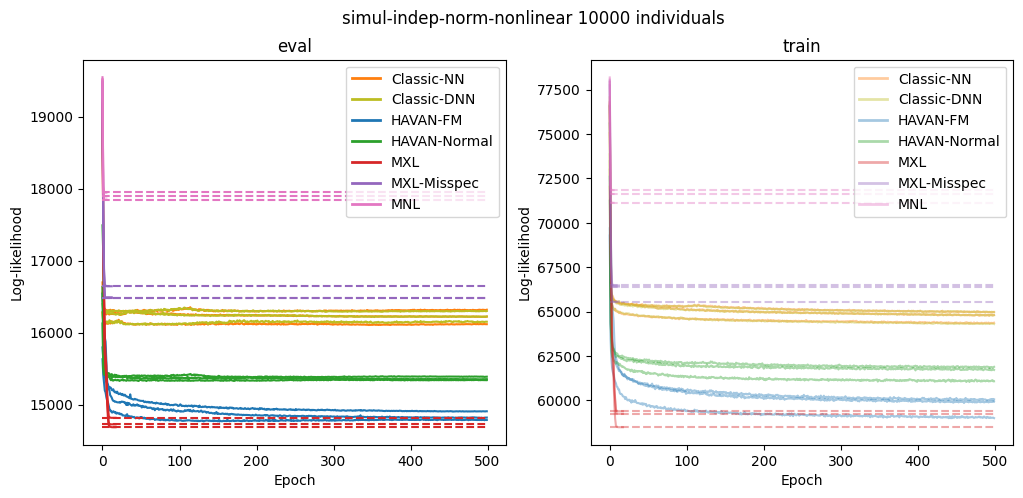

In [6]:
series = [{'color': 'tab:orange', 'name': 'Classic-NN', 'history': history_classic, 'incl_min': False},
          {'color': 'tab:olive', 'name': 'Classic-DNN', 'history': history_classic_dnn, 'incl_min': False},
          {'color': 'tab:blue', 'name': 'MAPL-FM', 'history': history_mapl, 'incl_min': False},
          {'color': 'tab:green', 'name': 'MAPL-Normal', 'history': history_son, 'incl_min': False},
          {'color': 'tab:red', 'name': 'MXL', 'history': history_mxl, 'incl_min': True},
          {'color': 'tab:purple', 'name': 'MXL-Misspec', 'history': history_mxl_misspec, 'incl_min': True},
          {'color': 'tab:pink', 'name': 'MNL', 'history': history_mnl, 'incl_min': True}
         ]

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_series(ax, series, subset="train"):
    alpha = 0.4 if subset=="train" else 1.0
    for s in series:
        for h in s['history']:
            data = [x['loss'] for x in h[subset]]
            ax.plot(data, s['color'], alpha=alpha)
            if s['incl_min']:
                ax.plot([np.min(data)]*n_epochs, c=s['color'], linestyle="--", alpha=alpha)
    custom_lines = [Line2D([0], [0], color=s['color'], lw=2, alpha=alpha) for s in series]
    ax.legend(custom_lines, [s['name'] for s in series])
    ax.set(xlabel='Epoch', ylabel='Log-likelihood', title=subset)
    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_series(ax1, series, subset="eval")
plot_series(ax2, series, subset="train")
fig.suptitle(dataset+" "+str(n_indiv)+" individuals")
#plt.show()
plt.savefig(f"plots_{dataset}_{n_indiv}-indiv.png", dpi=fig.dpi)

In [7]:
cols, data = [], []
for sub in ['eval', 'train']:
    for s in series:
        for trial, h in enumerate(s['history']):
            cols.append(f"{sub}_{s['name'].lower()}_trial-{trial}")
            data.append([x['loss'] for x in h[sub]])

df = pd.DataFrame({cols[i]:pd.Series(data[i]) for i in range(len(cols))}).to_csv(f"{dataset}_{n_indiv}-indiv.csv", index=False)